# Machine Learning Implementation (Random Forests)

This document contains the actual data splitting, training, and metrics for the following machine learning models

## Importing our libraries

In [25]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix,roc_auc_score, roc_curve
from sklearn.svm import SVC

from time import time
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import pickle

## Reading saved clean data

In [26]:
base_df = pd.read_pickle('cleaned_data_loan_approval.pkl')
base_no_outliers_df = pd.read_pickle('cleaned_data_loan_approval_without_outliers.pkl')

display(base_df.head())
print(base_df.shape)

display(base_no_outliers_df.head())
print(base_no_outliers_df.shape)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Education,Self_Employed,Loan_Status,Semiurban,Urban,1,2,3+
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,0,1,0,0,0
1,4583,1508.0,128.000000,360.0,1.0,1,1,0,0,0,0,0,1,0,0
2,3000,0.0,66.000000,360.0,1.0,1,1,0,1,1,0,1,0,0,0
3,2583,2358.0,120.000000,360.0,1.0,1,1,1,0,1,0,1,0,0,0
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,0,1,0,0,0


(614, 15)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Education,Self_Employed,Loan_Status,Semiurban,Urban,1,2,3+
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,0,1,0,0,0
1,4583,1508.0,128.000000,360.0,1.0,1,1,0,0,0,0,0,1,0,0
2,3000,0.0,66.000000,360.0,1.0,1,1,0,1,1,0,1,0,0,0
3,2583,2358.0,120.000000,360.0,1.0,1,1,1,0,1,0,1,0,0,0
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,0,1,0,0,0


(445, 15)


## Splitting Data

In [13]:
# Base Model
X = base_df[['LoanAmount','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','Credit_History','Gender', 'Married', 'Education', 'Self_Employed','Semiurban','Urban','1','2','3+' ]]
y = base_df['Loan_Status']

# With outliers removed
X_1 = base_no_outliers_df[['LoanAmount','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','Credit_History','Gender', 'Married', 'Education', 'Self_Employed','Semiurban','Urban','1','2','3+' ]]
y_1 = base_no_outliers_df['Loan_Status']

print(f'Shape: X{X.shape}, y{y.shape}')
print(f'Shape: X_1{X_1.shape}, y_1{y_1.shape}')

Shape: X(614, 14), y(614,)
Shape: X_1(445, 14), y_1(445,)


📝 These two are the same dataset but with different variations such as the (*)_1 not having outliers.

## Training Random Forest Models

### Base Models

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)

forest = RandomForestClassifier(n_estimators = 100)

forest.fit(X_train,y_train)

forest_pred = forest.predict(X_test)

print(classification_report(y_test, forest_pred))
df_matrix=pd.DataFrame(confusion_matrix(y_test, forest_pred), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
df_matrix.style.background_gradient(cmap='Blues')

              precision    recall  f1-score   support

           0       0.76      0.44      0.56        63
           1       0.76      0.93      0.84       122

    accuracy                           0.76       185
   macro avg       0.76      0.69      0.70       185
weighted avg       0.76      0.76      0.74       185



,Predicted False,Predicted True
Actual False,28,35
Actual True,9,113


⚠️**Author's Notes:** 
* This model gave us a 0.77 accuracy score however the recall for 0 is too low. Need to look into this and see if I can increase that value. 

### Without Outliers

In [34]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1,y_1,test_size = 0.3, random_state = 100)

forest_1 = RandomForestClassifier(n_estimators = 100)
forest_1.fit(X_train_1,y_train_1)

forest_pred_1 = forest_1.predict(X_test_1)

print(classification_report(y_test_1, forest_pred_1))
df_matrix=pd.DataFrame(confusion_matrix(y_test_1, forest_pred_1), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
df_matrix.style.background_gradient(cmap='Blues')

              precision    recall  f1-score   support

           0       0.67      0.34      0.45        35
           1       0.80      0.94      0.87        99

    accuracy                           0.78       134
   macro avg       0.73      0.64      0.66       134
weighted avg       0.77      0.78      0.76       134



,Predicted False,Predicted True
Actual False,12,23
Actual True,6,93


⚠️ **Author's Notes:** 
* This is not really the improvement I was hoping to see. The accuracy increased by 1% (which is negligible) while the 1 for both precision and recall remained the same (negligible improvement/decline). Need to look if there could be more improvements in the dataset.

## Feature Importance

In [23]:
def feature_plot(coef, columns,y_title = 'coefficients'):
    feature_imp = pd.DataFrame(coef.T, columns = ['importance'])
    feature_imp['feature'] = columns
    feature_imp.sort_values(by=['importance'], ascending = False, inplace = True)
    feature_imp.plot(x = 'feature', kind = 'bar', figsize = (16,4))
    plt.title(y_title)
    plt.ylabel(y_title)

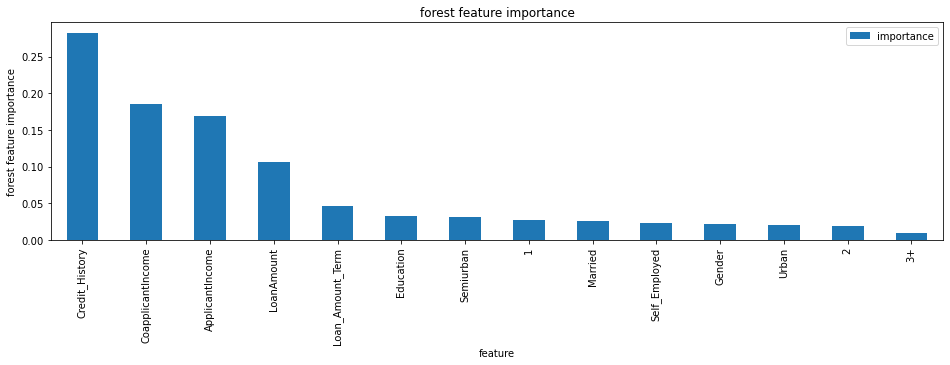

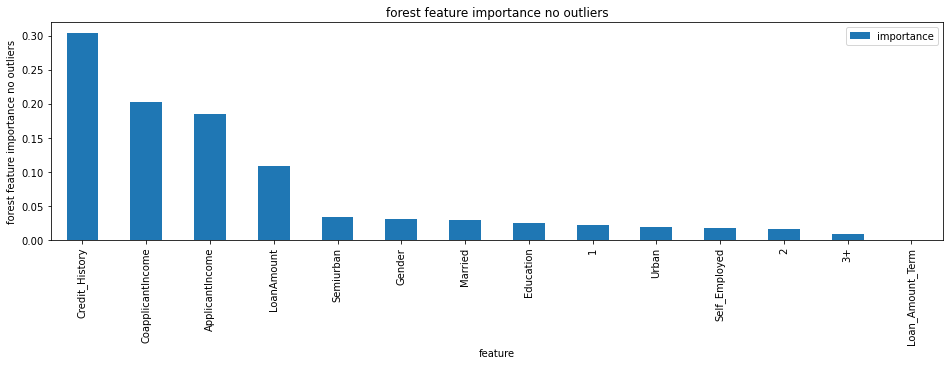

In [24]:
feature_names = list(base_df.columns)
feature_names_1 = list(base_no_outliers_df.columns)

feature_names.remove('Loan_Status')
feature_names_1.remove('Loan_Status')

feature_plot(coef= forest.feature_importances_, columns=feature_names, y_title='forest feature importance')
feature_plot(coef= forest_1.feature_importances_, columns=feature_names_1, y_title='forest feature importance no outliers')

⚠️ **Author's Notes**
* First observation shows that Credit_History, CoApplicantIncome, ApplicantIncome, and Loan Amount played a significant role in determining loan status. What stood out was that with the data set without outliers Loan Amount Term had no importance compared to the base data set with outliers. 

### Generating an ROC Curve for Base Model, GridSearch, and RandomSearch

These models will go off the data set without outliers.

In [64]:
# Modify the X_train and y_train in use for different variations of datasets.
# These temp variables will be used for both Randomized and GridSearch
X_train_temp = X_train
y_train_temp = y_train

X_test_temp = X_test
y_test_temp = y_test

#### Randomized Search

In [59]:
# Creating a base model
forest_base = RandomForestClassifier(n_estimators = 20)
param_distribution = {
    'max_depth':[2,3],
    'max_features': randint(1,13),
    'min_samples_split': randint(2,13),
    'criterion': ['gini','entropy']
}
n_iter_search = 15
# Creating a random search model
forest_random_search = RandomizedSearchCV(forest_base, param_distributions = param_distribution, n_iter = n_iter_search, cv = 5)
# Time the fitting of this model
start = time()
forest_random_search.fit(X_train_temp,y_train_temp)
print(f'RandomizedSearchCV took {round((time() - start), 2)} seconds for {n_iter_search} iterations of searches on given parameter settings.')
print(f'---------------------------------------------------------------------------')
print(f'Random Search Best Score: {round(forest_random_search.best_score_,3)}')
print(f'---------------------------------------------------------------------------')
print(f'Random Search Best Estimator:\n {forest_random_search.best_estimator_}')
print(f'---------------------------------------------------------------------------')
print(f'Random Search Best Params:\n {forest_random_search.best_params_}')
print(f'---------------------------------------------------------------------------')
print(f'Random Search Results:\n {forest_random_search.cv_results_.keys()}')

RandomizedSearchCV took 1.7 seconds for 15 iterations of searches on given parameter settings.
---------------------------------------------------------------------------
Random Search Best Score: 0.823
---------------------------------------------------------------------------
Random Search Best Estimator:
 RandomForestClassifier(max_depth=2, max_features=6, min_samples_split=11,
                       n_estimators=20)
---------------------------------------------------------------------------
Random Search Best Params:
 {'criterion': 'gini', 'max_depth': 2, 'max_features': 6, 'min_samples_split': 11}
---------------------------------------------------------------------------
Random Search Results:
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_t

In [63]:
forest_random_search_pred = forest_random_search.predict(X_test_temp)
print(classification_report(y_test_temp, forest_random_search_pred))

df_matrix=pd.DataFrame(confusion_matrix(y_test_temp, forest_random_search_pred), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
df_matrix.style.background_gradient(cmap='Blues')

              precision    recall  f1-score   support

           0       0.89      0.40      0.55        63
           1       0.76      0.98      0.85       122

    accuracy                           0.78       185
   macro avg       0.83      0.69      0.70       185
weighted avg       0.80      0.78      0.75       185



,Predicted False,Predicted True
Actual False,25,38
Actual True,3,119


In [68]:
def print_report(search_results, top_n = 2):
    for i in range(1, top_n + 1):
        rank = np.flatnonzero(search_results['rank_test_score'] == i)
        for val in rank: 
            print("Model rank: ", i)
            print("Mean validation score: {:.3f}".format(search_results['mean_test_score'][val]))
            print("std_test_score: {:.3f}".format(search_results['std_test_score'][val]))
            print("Parameters: {}\n".format(format(search_results['params'][val])))

In [69]:
print_report(forest_random_search.cv_results_, 3)

Model rank:  1
Mean validation score: 0.823
std_test_score: 0.024
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 6, 'min_samples_split': 11}

Model rank:  1
Mean validation score: 0.823
std_test_score: 0.024
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 9, 'min_samples_split': 7}

Model rank:  1
Mean validation score: 0.823
std_test_score: 0.024
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 11, 'min_samples_split': 8}

Model rank:  1
Mean validation score: 0.823
std_test_score: 0.024
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 6, 'min_samples_split': 12}



⚠️**Author's Notes:**

* All of these produce the same result. Is there an error in my methods?

#### GridSearch

In [ ]:
forest_random = RandomForestClassifier(n_estimators=20)
param_grid = {
    'max_depth': [2,3],
    'max_features': [3,5,13],
    'min_samples_split': [2,3,13],
    'criterion': ['gini','entropy']
}
grid_search_rfc = GridSearchCV(rfc_GS,param_grid=param_grid,cv=5)
start = time()
grid_search_rfc.fit(X_train,y_train)
print(f'GridSearchCV took {time() - start} for ')
print(len(grid_search_rfc.cv_results_['params']))
print('candidate parameter settings.')